In [32]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
import matplotlib.pyplot as plt

In [33]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [34]:
count_vst = pd.read_csv("/habib_markers_analysis/habib_marker_peaks_vst_count_matrix.txt", sep="\t")
sampleInfoSorted = pd.read_csv("/habib_markers_analysis/habib_marker_peaks_sample_info_sorted.txt", sep="\t")

In [35]:
countsDict = dict()

In [36]:
for index, row in sampleInfoSorted.iterrows():
    count_data = count_vst[[row.name]]
    if not (row.proj_id, row.brain_region) in countsDict:
        countsDict[row.proj_id,row.brain_region] = dict()
    countsDict[row.proj_id,row.brain_region][row.cell_type] = count_data[[row.name]].values

In [37]:
glial2fcMatrix = []
microglial2fcMatrix = []
neuronl2fcMatrix = []
sampleList = []
for sample in countsDict:
    if "Microglia" in countsDict[sample] and "Glia" in countsDict[sample] and "Neuron" in countsDict[sample]:
        meanGliaBackground = (countsDict[sample]['Microglia'] + countsDict[sample]['Neuron'])/2.0
        glial2fc = np.log2(np.divide(countsDict[sample]['Glia'],meanGliaBackground))
        glial2fcMatrix.append(glial2fc)
        
        meanNeuronBackground = (countsDict[sample]['Microglia'] + countsDict[sample]['Glia'])/2.0
        neuronl2fc = np.log2(np.divide(countsDict[sample]['Neuron'],meanNeuronBackground))
        neuronl2fcMatrix.append(neuronl2fc)

        meanMicrogliaBackground = (countsDict[sample]['Glia'] + countsDict[sample]['Neuron'])/2.0
        microglial2fc = np.log2(np.divide(countsDict[sample]['Microglia'],meanMicrogliaBackground))
        microglial2fcMatrix.append(microglial2fc)
        
        sampleList.append(sample)

glial2fcMatrix = np.concatenate(glial2fcMatrix, axis=1)
neuronl2fcMatrix = np.concatenate(neuronl2fcMatrix, axis=1)
microglial2fcMatrix = np.concatenate(microglial2fcMatrix, axis=1)

In [38]:
#Run when filtering by distance to tss <5kb peaks
lengths = [290,
          163,
          233,
          368,
          475,
          288,
          336,
          161,
          290,
          412,
          118,
          299,
          355,
          737,
          936]


In [27]:
#Run when not filtering by distance to tss
lengths = [3389,
            1922,
            2887,
            4010,
            5542,
            3410,
            4262,
            2078,
            2900,
            4751,
            1457,
            2422,
            3172,
            5373,
            5573]


In [39]:
l2fcCutoff = 0.1

In [40]:
start = 0
end = 0
neuronL2fcTable = []
microgliaL2fcTable = []
gliaL2fcTable = []

neuronTstatTable = []
microgliaTstatTable = []
gliaTstatTable = []

neuronPvalTable = []
microgliaPvalTable = []
gliaPvalTable = []

for i in range(len(lengths)):
    start = end
    end = end + lengths[i]
    meanGliaL2fcSubset = np.mean(glial2fcMatrix[start:end,:], axis=0)
    meanMicrogliaL2fcSubset = np.mean(microglial2fcMatrix[start:end,:], axis=0)
    meanNeuronL2fcSubset = np.mean(neuronl2fcMatrix[start:end,:], axis=0)
    
    gliaTstat, gliaPval = stats.ttest_1samp(glial2fcMatrix[start:end,:], l2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(microglial2fcMatrix[start:end,:], l2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(neuronl2fcMatrix[start:end,:], l2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)

    gliaTstatTable.append(gliaTstat)
    neuronTstatTable.append(neuronTstat)
    microgliaTstatTable.append(microgliaTstat)
    gliaPvalTable.append(gliaPval)
    neuronPvalTable.append(neuronPval)
    microgliaPvalTable.append(microgliaPval)        
        
    
    gliaL2fcTable.append(meanGliaL2fcSubset)
    neuronL2fcTable.append(meanNeuronL2fcSubset)
    microgliaL2fcTable.append(meanMicrogliaL2fcSubset)

    
    
gliaL2fcTable = np.stack(gliaL2fcTable, axis=1)
neuronL2fcTable = np.stack(neuronL2fcTable, axis=1)
microgliaL2fcTable = np.stack(microgliaL2fcTable, axis=1)

gliaTstatTable = np.stack(gliaTstatTable, axis=1)
neuronTstatTable = np.stack(neuronTstatTable, axis=1)
microgliaTstatTable = np.stack(microgliaTstatTable, axis=1)


gliaPvalTable = np.stack(gliaPvalTable, axis=1)
neuronPvalTable = np.stack(neuronPvalTable, axis=1)
microgliaPvalTable = np.stack(microgliaPvalTable, axis=1)

/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


In [41]:
l2fcData = np.concatenate((neuronL2fcTable, microgliaL2fcTable, gliaL2fcTable), axis=1)
tStatData = np.concatenate((neuronTstatTable, microgliaTstatTable, gliaTstatTable), axis=1)
pValData = np.concatenate((neuronPvalTable, microgliaPvalTable, gliaPvalTable ), axis=1)
pValData = np.maximum(pValData - np.log10(pValData.size), 0)

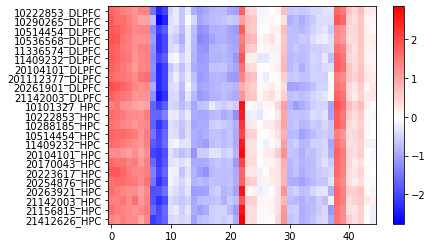

In [42]:
l2fcData = stats.zscore(l2fcData, axis=1)

vmax = np.amax(l2fcData)
vmin = np.amin(l2fcData)
vmid = 1 - vmax / (vmax + abs(vmin))
new_cmap = shiftedColorMap(matplotlib.cm.bwr, midpoint=vmid, name='shrunk')

fig, ax = plt.subplots()
im = ax.imshow(l2fcData, aspect="auto", cmap=new_cmap)
ax.set_yticks(range(len(sampleList)))
ax.set_yticklabels([(str(val[0])+"_"+str(val[1])) for val in sampleList])
ax.figure.colorbar(im, ax=ax)
plt.savefig("markers_sample_level_l2fc_heatmap_disttss_filtered.svg")

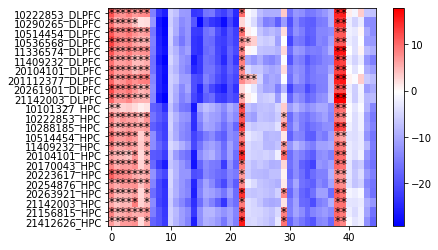

In [43]:
vmax = np.amax(tStatData)
vmin = np.amin(tStatData)
vmid = 1 - vmax / (vmax + abs(vmin))
new_cmap = shiftedColorMap(matplotlib.cm.bwr, midpoint=vmid, name='shrunk')

fig, ax = plt.subplots()
im = ax.imshow(tStatData, aspect="auto", cmap=new_cmap)
ax.set_yticks(range(len(sampleList)))
ax.set_yticklabels([(str(val[0])+"_"+str(val[1])) for val in sampleList])
ax.figure.colorbar(im, ax=ax)

for i in range(pValData.shape[0]):
    for j in range(pValData.shape[1]):
        sig = ""
        if pValData[i,j] > -np.log10(0.05):
            sig = "*"
        if tStatData[i,j] > 0:
            text = ax.text(j, i, sig,
                ha="center", va="center", color="k", fontsize=12)

plt.savefig("markers_sample_level_tstat_heatmap_disttss_filtered.svg")


In [44]:
groupL2fcCutoff = 0.2

In [45]:
#AD samples only
adCountsData = dict()
nonADCountsData = dict()
maleCountsData = dict()
femaleCountsData = dict()
hipCountsData = dict()
pfcCountsData = dict()

for _,indSampleInfo in sampleInfoSorted.iterrows():
    proj_id = indSampleInfo.proj_id
    brain_region = indSampleInfo.brain_region
    binary_amyloid = indSampleInfo.binary_amyloid
    sex = indSampleInfo.msex
    
    countData = countsDict[proj_id, brain_region]
    
    if binary_amyloid == 0:
        for key in countData:
            if not key in nonADCountsData:
                nonADCountsData[key] = countData[key]
            else:
                nonADCountsData[key] = nonADCountsData[key] + countData[key]
    elif binary_amyloid == 1:
        for key in countData:
            if not key in adCountsData:
                adCountsData[key] = countData[key]
            else:
                adCountsData[key] = adCountsData[key] + countData[key]
    if sex == 0:
        for key in countData:
            if not key in femaleCountsData:
                femaleCountsData[key] = countData[key]
            else:
                femaleCountsData[key] = femaleCountsData[key] + countData[key]  
    elif sex == 1:
        for key in countData:
            if not key in maleCountsData:
                maleCountsData[key] = countData[key]
            else:
                maleCountsData[key] = maleCountsData[key] + countData[key]
    if brain_region == "HPC":
        for key in countData:
            if not key in hipCountsData:
                hipCountsData[key] = countData[key]
            else:
                hipCountsData[key] = hipCountsData[key] + countData[key]  
    elif brain_region == "DLPFC":
        for key in countData:
            if not key in pfcCountsData:
                pfcCountsData[key] = countData[key]
            else:
                pfcCountsData[key] = pfcCountsData[key] + countData[key]

In [46]:
meanADGliaBackground = (adCountsData['Microglia'] + adCountsData['Neuron'])/2.0
adglial2fc = np.log2(np.divide(adCountsData['Glia'],meanADGliaBackground))

meanADNeuronBackground = (adCountsData['Microglia'] + adCountsData['Glia'])/2.0
adneuronl2fc = np.log2(np.divide(adCountsData['Neuron'],meanADNeuronBackground))

meanADMicrogliaBackground = (adCountsData['Glia'] + adCountsData['Neuron'])/2.0
admicroglial2fc = np.log2(np.divide(adCountsData['Microglia'],meanADMicrogliaBackground))

meannonADGliaBackground = (nonADCountsData['Microglia'] + nonADCountsData['Neuron'])/2.0
nonADglial2fc = np.log2(np.divide(nonADCountsData['Glia'],meannonADGliaBackground))

meannonADNeuronBackground = (nonADCountsData['Microglia'] + nonADCountsData['Glia'])/2.0
nonADneuronl2fc = np.log2(np.divide(nonADCountsData['Neuron'],meannonADNeuronBackground))

meannonADMicrogliaBackground = (nonADCountsData['Glia'] + nonADCountsData['Neuron'])/2.0
nonADmicroglial2fc = np.log2(np.divide(nonADCountsData['Microglia'],meannonADMicrogliaBackground))


meanFemaleGliaBackground = (femaleCountsData['Microglia'] + femaleCountsData['Neuron'])/2.0
femaleglial2fc = np.log2(np.divide(femaleCountsData['Glia'],meanFemaleGliaBackground))

meanFemaleNeuronBackground = (femaleCountsData['Microglia'] + femaleCountsData['Glia'])/2.0
femaleneuronl2fc = np.log2(np.divide(femaleCountsData['Neuron'],meanFemaleNeuronBackground))

meanFemaleMicrogliaBackground = (femaleCountsData['Glia'] + femaleCountsData['Neuron'])/2.0
femalemicroglial2fc = np.log2(np.divide(femaleCountsData['Microglia'],meanFemaleMicrogliaBackground))

meanMaleGliaBackground = (maleCountsData['Microglia'] + maleCountsData['Neuron'])/2.0
maleglial2fc = np.log2(np.divide(maleCountsData['Glia'],meanMaleGliaBackground))

meanMaleNeuronBackground = (maleCountsData['Microglia'] + maleCountsData['Glia'])/2.0
maleneuronl2fc = np.log2(np.divide(maleCountsData['Neuron'],meanMaleNeuronBackground))

meanMaleMicrogliaBackground = (maleCountsData['Glia'] + maleCountsData['Neuron'])/2.0
malemicroglial2fc = np.log2(np.divide(maleCountsData['Microglia'],meanMaleMicrogliaBackground))


meanHipGliaBackground = (hipCountsData['Microglia'] + hipCountsData['Neuron'])/2.0
hipglial2fc = np.log2(np.divide(hipCountsData['Glia'],meanHipGliaBackground))

meanHipNeuronBackground = (hipCountsData['Microglia'] + hipCountsData['Glia'])/2.0
hipneuronl2fc = np.log2(np.divide(hipCountsData['Neuron'],meanHipNeuronBackground))

meanHipMicrogliaBackground = (hipCountsData['Glia'] + hipCountsData['Neuron'])/2.0
hipmicroglial2fc = np.log2(np.divide(hipCountsData['Microglia'],meanHipMicrogliaBackground))

meanPfcGliaBackground = (pfcCountsData['Microglia'] + pfcCountsData['Neuron'])/2.0
pfcglial2fc = np.log2(np.divide(pfcCountsData['Glia'],meanPfcGliaBackground))

meanPfcNeuronBackground = (pfcCountsData['Microglia'] + pfcCountsData['Glia'])/2.0
pfcneuronl2fc = np.log2(np.divide(pfcCountsData['Neuron'],meanPfcNeuronBackground))

meanPfcMicrogliaBackground = (pfcCountsData['Glia'] + pfcCountsData['Neuron'])/2.0
pfcmicroglial2fc = np.log2(np.divide(pfcCountsData['Microglia'],meanPfcMicrogliaBackground))


In [47]:
start = 0
end = 0
adneuronL2fc = []
admicrogliaL2fc = []
adgliaL2fc = []

nonADneuronL2fc = []
nonADmicrogliaL2fc = []
nonADgliaL2fc = []

femaleneuronL2fc = []
femalemicrogliaL2fc = []
femalegliaL2fc = []

maleneuronL2fc = []
malemicrogliaL2fc = []
malegliaL2fc = []

hipneuronL2fc = []
hipmicrogliaL2fc = []
hipgliaL2fc = []

pfcneuronL2fc = []
pfcmicrogliaL2fc = []
pfcgliaL2fc = []


adneuronTstat = []
admicrogliaTstat = []
adgliaTstat = []

nonADneuronTstat = []
nonADmicrogliaTstat = []
nonADgliaTstat = []

femaleneuronTstat = []
femalemicrogliaTstat = []
femalegliaTstat = []

maleneuronTstat = []
malemicrogliaTstat = []
malegliaTstat = []

hipneuronTstat = []
hipmicrogliaTstat = []
hipgliaTstat = []

pfcneuronTstat = []
pfcmicrogliaTstat = []
pfcgliaTstat = []

adneuronPval = []
admicrogliaPval = []
adgliaPval = []

nonADneuronPval = []
nonADmicrogliaPval = []
nonADgliaPval = []

femaleneuronPval = []
femalemicrogliaPval = []
femalegliaPval = []

maleneuronPval = []
malemicrogliaPval = []
malegliaPval = []

hipneuronPval = []
hipmicrogliaPval = []
hipgliaPval = []

pfcneuronPval = []
pfcmicrogliaPval = []
pfcgliaPval = []



for i in range(len(lengths)):
    start = end
    end = end + lengths[i]

    meanADGliaL2fcSubset = np.mean(adglial2fc[start:end])
    meanADMicrogliaL2fcSubset = np.mean(admicroglial2fc[start:end])
    meanADNeuronL2fcSubset = np.mean(adneuronl2fc[start:end])
    
    gliaTstat, gliaPval = stats.ttest_1samp(adglial2fc[start:end], groupL2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(admicroglial2fc[start:end], groupL2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(adneuronl2fc[start:end], groupL2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)
    
    
    adgliaTstat.append(gliaTstat)
    adneuronTstat.append(neuronTstat)
    admicrogliaTstat.append(microgliaTstat)
    adgliaPval.append(gliaPval)
    adneuronPval.append(neuronPval)
    admicrogliaPval.append(microgliaPval)        
    
    adgliaL2fc.append(meanADGliaL2fcSubset)
    adneuronL2fc.append(meanADNeuronL2fcSubset)
    admicrogliaL2fc.append(meanADMicrogliaL2fcSubset)
    
    meannonADGliaL2fcSubset = np.mean(nonADglial2fc[start:end])
    meannonADMicrogliaL2fcSubset = np.mean(nonADmicroglial2fc[start:end])
    meannonADNeuronL2fcSubset = np.mean(nonADneuronl2fc[start:end])

    gliaTstat, gliaPval = stats.ttest_1samp(nonADglial2fc[start:end], l2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(nonADmicroglial2fc[start:end], l2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(nonADneuronl2fc[start:end], l2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)
  
    nonADgliaTstat.append(gliaTstat)
    nonADneuronTstat.append(neuronTstat)
    nonADmicrogliaTstat.append(microgliaTstat)
    nonADgliaPval.append(gliaPval)
    nonADneuronPval.append(neuronPval)
    nonADmicrogliaPval.append(microgliaPval)      
    
    nonADgliaL2fc.append(meannonADGliaL2fcSubset)
    nonADneuronL2fc.append(meannonADNeuronL2fcSubset)
    nonADmicrogliaL2fc.append(meannonADMicrogliaL2fcSubset)
    
    meanFemaleGliaL2fcSubset = np.mean(femaleglial2fc[start:end])
    meanFemaleMicrogliaL2fcSubset = np.mean(femalemicroglial2fc[start:end])
    meanFemaleNeuronL2fcSubset = np.mean(femaleneuronl2fc[start:end])

    gliaTstat, gliaPval = stats.ttest_1samp(femaleglial2fc[start:end], l2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(femalemicroglial2fc[start:end], l2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(femaleneuronl2fc[start:end], l2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)
    
    
    femalegliaTstat.append(gliaTstat)
    femaleneuronTstat.append(neuronTstat)
    femalemicrogliaTstat.append(microgliaTstat)
    femalegliaPval.append(gliaPval)
    femaleneuronPval.append(neuronPval)
    femalemicrogliaPval.append(microgliaPval)      
    
    femalegliaL2fc.append(meanFemaleGliaL2fcSubset)
    femaleneuronL2fc.append(meanFemaleNeuronL2fcSubset)
    femalemicrogliaL2fc.append(meanFemaleMicrogliaL2fcSubset)
    
    meanMaleGliaL2fcSubset = np.mean(maleglial2fc[start:end])
    meanMaleMicrogliaL2fcSubset = np.mean(malemicroglial2fc[start:end])
    meanMaleNeuronL2fcSubset = np.mean(maleneuronl2fc[start:end])

    gliaTstat, gliaPval = stats.ttest_1samp(maleglial2fc[start:end], l2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(malemicroglial2fc[start:end], l2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(maleneuronl2fc[start:end], l2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)
    
    malegliaTstat.append(gliaTstat)
    maleneuronTstat.append(neuronTstat)
    malemicrogliaTstat.append(microgliaTstat)
    malegliaPval.append(gliaPval)
    maleneuronPval.append(neuronPval)
    malemicrogliaPval.append(microgliaPval)  
    
    malegliaL2fc.append(meanMaleGliaL2fcSubset)
    maleneuronL2fc.append(meanMaleNeuronL2fcSubset)
    malemicrogliaL2fc.append(meanMaleMicrogliaL2fcSubset)
    
    meanHipGliaL2fcSubset = np.mean(hipglial2fc[start:end])
    meanHipMicrogliaL2fcSubset = np.mean(hipmicroglial2fc[start:end])
    meanHipNeuronL2fcSubset = np.mean(hipneuronl2fc[start:end])
    

    gliaTstat, gliaPval = stats.ttest_1samp(hipglial2fc[start:end], l2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(hipmicroglial2fc[start:end], l2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(hipneuronl2fc[start:end], l2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)
    
    hipgliaTstat.append(gliaTstat)
    hipneuronTstat.append(neuronTstat)
    hipmicrogliaTstat.append(microgliaTstat)
    hipgliaPval.append(gliaPval)
    hipneuronPval.append(neuronPval)
    hipmicrogliaPval.append(microgliaPval) 
    
    hipgliaL2fc.append(meanHipGliaL2fcSubset)
    hipneuronL2fc.append(meanHipNeuronL2fcSubset)
    hipmicrogliaL2fc.append(meanHipMicrogliaL2fcSubset)
    
    
    meanPfcGliaL2fcSubset = np.mean(pfcglial2fc[start:end])
    meanPfcMicrogliaL2fcSubset = np.mean(pfcmicroglial2fc[start:end])
    meanPfcNeuronL2fcSubset = np.mean(pfcneuronl2fc[start:end])

    gliaTstat, gliaPval = stats.ttest_1samp(pfcglial2fc[start:end], l2fcCutoff, axis=0)
    gliaPval = np.multiply(gliaPval, gliaTstat>0)
    gliaPval = -np.log10(gliaPval/2)

    microgliaTstat, microgliaPval = stats.ttest_1samp(pfcmicroglial2fc[start:end], l2fcCutoff, axis=0)
    microgliaPval = np.multiply(microgliaPval, microgliaTstat>0)
    microgliaPval = -np.log10(microgliaPval/2)

    neuronTstat, neuronPval = stats.ttest_1samp(pfcneuronl2fc[start:end], l2fcCutoff, axis=0)
    neuronPval = np.multiply(neuronPval, neuronTstat>0)
    neuronPval = -np.log10(neuronPval/2)
    
    pfcgliaTstat.append(gliaTstat)
    pfcneuronTstat.append(neuronTstat)
    pfcmicrogliaTstat.append(microgliaTstat)
    pfcgliaPval.append(gliaPval)
    pfcneuronPval.append(neuronPval)
    pfcmicrogliaPval.append(microgliaPval) 
    
    pfcgliaL2fc.append(meanPfcGliaL2fcSubset)
    pfcneuronL2fc.append(meanPfcNeuronL2fcSubset)
    pfcmicrogliaL2fc.append(meanPfcMicrogliaL2fcSubset)

/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in log10
/home/eramamur/bin/miniconda3/envs/data_analysis/lib/python3.7/sit

In [48]:
adL2fcData = np.concatenate((adneuronL2fc, admicrogliaL2fc, adgliaL2fc))
nonADL2fcData = np.concatenate((nonADneuronL2fc, nonADmicrogliaL2fc, nonADgliaL2fc))
femaleL2fcData = np.concatenate((femaleneuronL2fc, femalemicrogliaL2fc, femalegliaL2fc))
maleL2fcData = np.concatenate((maleneuronL2fc, malemicrogliaL2fc, malegliaL2fc))
hipL2fcData = np.concatenate((hipneuronL2fc, hipmicrogliaL2fc, hipgliaL2fc))
pfcL2fcData = np.concatenate((pfcneuronL2fc, pfcmicrogliaL2fc, pfcgliaL2fc))


adTstatData = np.concatenate((adneuronTstat, admicrogliaTstat, adgliaTstat))
nonADTstatData = np.concatenate((nonADneuronTstat, nonADmicrogliaTstat, nonADgliaTstat))
femaleTstatData = np.concatenate((femaleneuronTstat, femalemicrogliaTstat, femalegliaTstat))
maleTstatData = np.concatenate((maleneuronTstat, malemicrogliaTstat, malegliaTstat))
hipTstatData = np.concatenate((hipneuronTstat, hipmicrogliaTstat, hipgliaTstat))
pfcTstatData = np.concatenate((pfcneuronTstat, pfcmicrogliaTstat, pfcgliaTstat))


adPvalData = np.concatenate((adneuronPval, admicrogliaPval, adgliaPval))
nonADPvalData = np.concatenate((nonADneuronPval, nonADmicrogliaPval, nonADgliaPval))
femalePvalData = np.concatenate((femaleneuronPval, femalemicrogliaPval, femalegliaPval))
malePvalData = np.concatenate((maleneuronPval, malemicrogliaPval, malegliaPval))
hipPvalData = np.concatenate((hipneuronPval, hipmicrogliaPval, hipgliaPval))
pfcPvalData = np.concatenate((pfcneuronPval, pfcmicrogliaPval, pfcgliaPval))

In [49]:
finalL2fcData = np.stack((adL2fcData, nonADL2fcData, femaleL2fcData, maleL2fcData, hipL2fcData, pfcL2fcData))
finalTstatData = np.squeeze(np.stack((adTstatData, nonADTstatData, femaleTstatData, maleTstatData, hipTstatData, pfcTstatData)))
finalPvalData = np.squeeze(np.stack((adPvalData, nonADPvalData, femalePvalData, malePvalData, hipPvalData, pfcPvalData)))
finalPvalData = np.maximum(finalPvalData - np.log10(finalPvalData.size), 0)

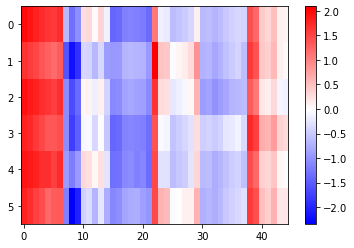

In [50]:
finalL2fcData = stats.zscore(finalL2fcData, axis=1)

vmax = np.amax(finalL2fcData)
vmin = np.amin(finalL2fcData)
vmid = 1 - vmax / (vmax + abs(vmin))
new_cmap = shiftedColorMap(matplotlib.cm.bwr, midpoint=vmid, name='shrunk')

fig, ax = plt.subplots()
im = ax.imshow(finalL2fcData, aspect="auto", cmap=new_cmap)
ax.figure.colorbar(im, ax=ax)
plt.savefig('groupwise_l2fc_heatmap_disttss_filtered.svg')

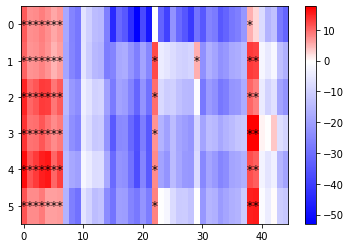

In [51]:
vmax = np.amax(finalTstatData)
vmin = np.amin(finalTstatData)
vmid = 1 - vmax / (vmax + abs(vmin))
new_cmap = shiftedColorMap(matplotlib.cm.bwr, midpoint=vmid, name='shrunk')

fig, ax = plt.subplots()
im = ax.imshow(finalTstatData, aspect="auto", cmap=new_cmap)
ax.figure.colorbar(im, ax=ax)

for i in range(finalPvalData.shape[0]):
    for j in range(finalPvalData.shape[1]):
        sig = ""
        if finalPvalData[i,j] > -np.log10(0.05):
            sig = "*"
        if finalTstatData[i,j] > 0:
            text = ax.text(j, i, sig,
                ha="center", va="center", color="k", fontsize=12)

plt.savefig("groupwise_tstat_heatmap_disttss_filtered.svg")